## Mermory
In LangGraph, "memory" refers to how your agent or system remembers past interactions and information throughout a conversation or a series of steps. It's crucial for maintaining context, enabling more coherent and intelligent responses, and allowing your agent to make decisions based on previous states.
Think of it like a human conversation: if you're talking to someone, you remember what you just discussed. Memory in LangGraph serves the same purpose for your AI.
Here's an easier way to understand it, along with the types of memory:

#### What is Memory?
Imagine you're playing a game of "20 Questions" with an AI.

- Without memory: Every question is brand new. The AI might ask "Is it an animal?" then later "Is it alive?" even if you already said "Yes" to the first question and that implies it's alive. It forgets everything immediately.

- With memory: The AI remembers your previous answers. If you said "Yes, it's an animal," it won't ask if it's alive, but might then ask "Does it have fur?" or "Does it fly?" It builds on past information.

In LangGraph, memory stores the state of your graph at various points. This state can include:
The conversation history (user inputs and AI outputs).
Variables you've set (e.g., a user's name, a selected item).
Decisions made by the agent.
Results of tool calls.
This stored state is then passed to subsequent nodes in your graph, allowing them to access and use that information.
Types of Memory in LangGraph (and LangChain, which LangGraph builds upon)
While LangGraph itself leverages LangChain's extensive memory system, the core idea revolves around how much history is kept and how it's summarized. Here 

#### are some common types:
- ConversationBufferMemory (or Basic Conversation History):

`How it works:` This is the simplest form. It literally stores the raw text of the entire conversation (user input and AI output) in a list.


`Analogy:` It's like having a full transcript of your chat open in front of you.

`Pros:` Easy to implement, preserves all details.

`Cons:` Can get very long and consume a lot of token space (and cost) for large language models, especially in long conversations. The LLM has to read through everything each time.

*When to use: Short, focused conversations where you need full recall.*

- ConversationSummaryMemory:

`How it works:` Instead of storing every single message, this memory uses an LLM to periodically summarize the conversation so far. It keeps the summary and adds new messages to it.

`Analogy:` Imagine you have a secretary who occasionally writes a concise memo summarizing the meeting's discussion points, and then you just read the memo and the latest few comments.

`Pros:` Reduces token usage significantly for long conversations, maintains the gist of the discussion.

`Cons:` Some fine details might be lost in the summarization process. The LLM has to spend tokens generating the summary.

`When to use:` Long, open-ended conversations where exact phrasing isn't critical, but context is.

- ConversationBufferWindowMemory:

`How it works:` This memory stores only the last k interactions (e.g., the last 5 user-AI exchanges). When a new interaction comes in, the oldest one is dropped.

`Analogy:` It's like looking at the last few messages in a chat window. You can scroll up a bit, but not forever.

`Pros:` Fixed token usage, avoids overwhelming the LLM with too much history.

`Cons:` Can "forget" important details from earlier in the conversation if they fall outside the window.

`When to use:` Situations where only recent context is relevant, or to limit costs and computational load.

- ConversationTokenBufferMemory:

`How it works:` Similar to ConversationBufferWindowMemory, but instead of a fixed number of interactions, it keeps interactions until a certain token limit is reached. When the limit is exceeded, it prunes the oldest messages.

`Analogy:` Like the window memory, but it's smarter about how much text it's keeping, not just how many turns.

`Pros:` More precise control over token usage, which directly impacts cost and LLM context window limits.

`Cons:` Can still lose older context.

`When to use:` When you need strict control over the token count passed to the LLM.

- ConversationSummaryBufferMemory:

`How it works:` This is a hybrid approach. It keeps a buffer of recent interactions (like ConversationBufferWindowMemory), but when the buffer gets too large, it summarizes the older parts of the conversation into a running summary.

`Analogy:` You keep a transcript of the last few minutes of a meeting, but for everything before that, you just have a summary report.

`Pros:` Best of both worlds – detailed recent context and summarized long-term context. Excellent for balancing detail and token usage.

`Cons:` Slightly more complex to manage than simpler types.

`When to use:` Often a good default choice for general-purpose conversational agents.

#### How Memory Fits into LangGraph
In LangGraph, your graph's state is inherently where memory lives. When you define your graph, you specify the StateGraph and its schema. You can then use various checkpoints or memory components (often provided by LangChain) to store and retrieve this state.
For example, when you save a checkpoint in LangGraph, you're essentially saving the current state of your graph, which includes the conversation history or any other variables you've defined. When the graph resumes, it loads this saved state, making it "remember" where it left off.

In [9]:

import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

LLM = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [10]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

llm_with_tools = LLM.bind_tools(tools)

In [11]:
import sys
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing mathematical operations.")

def assistant(state: MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state['messages'])]}

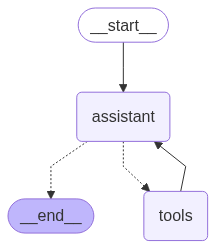

In [12]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

Without Agentic Memory

In [13]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

To add 3 and 4 using the provided tools, I will use the 'add' function with the arguments a=3 and b=4.
Tool Calls:
  add (hq9be927c)
 Call ID: hq9be927c
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.


In [14]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (fsyedxptf)
 Call ID: fsyedxptf
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10
================================== Ai Message ==================================

It seems like you've provided the number 10, but I'm not sure what operation you'd like me to perform next. Could you clarify what you'd like to do? For example, would you like to add, multiply, or divide this number with another? Let me know!


We don't retain memory of 7 from our initial chat!

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions. 

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

## With agentic Memory

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory_saver = MemorySaver()  # save memory in RAM
react_graph_memory = builder.compile(checkpointer=memory_saver)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)

In [17]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

To add 3 and 4, I will use the add function.
Tool Calls:
  add (v75688kwc)
 Call ID: v75688kwc
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  add (a6fkqwh4p)
 Call ID: a6fkqwh4p
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  add (cp1g3287c)
 Call ID: cp1g3287c
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  add (06sgcr

In [18]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

To add 3 and 4, I will use the add function.
Tool Calls:
  add (v75688kwc)
 Call ID: v75688kwc
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  add (a6fkqwh4p)
 Call ID: a6fkqwh4p
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  add (cp1g3287c)
 Call ID: cp1g3287c
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  add (06sgcr